<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product ">
</a>


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


<h1>Objective</h1><ul><li> How to use linear classifier in pytorch.</li></ul>


<h1>Linear  Classifier with PyTorch </h1>


<p>Before you use a  Deep neural network to solve the classification problem,  it 's a good idea to try and solve the problem with the simplest method. You will need the dataset object from the previous section.
In this lab, we solve the problem with a linear classifier.
 You will be asked to determine the maximum accuracy your linear classifier can achieve on the validation data for 5 epochs. We will give some free parameter values if you follow the instructions you will be able to answer the quiz. Just like the other labs there are several steps, but in this lab you will only be quizzed on the final result. </p>


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#download_data"> Download data</a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#trasform_Data_object">Transform Object and Dataset Object</a></li>
    <li><a href="#Question">Question</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>
 </div>
<hr>


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


In [ ]:
!pip install skillsnetwork

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00


The following are the libraries we are going to use for this lab:


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import skillsnetwork

import numpy as np
from tqdm import tqdm

<h2 id="download_data">Download Data</h2>


In this section, you are going to download the data from IBM object storage using **skillsnetwork.prepare** command. <b>skillsnetwork.prepare</b> is a command that's used to download a zip file, unzip it and store it in a specified directory. Locally we store the data in the directory  **/resources/data**.


In [ ]:
pwd

'/content'

In [ ]:
import os

# Specify the folder path
folder_path = '/content/resources/data'

# Create the folder
os.makedirs(folder_path, exist_ok=True)

# Verify that the folder is created
print(f"The folder {folder_path} has been created.")

The folder /content/resources/data has been created.


First, we download the file that contains the images:


In [ ]:
await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip", path = "resources/data", overwrite=True)

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved to 'resources/data'


<h2 id="data_class">Dataset Class</h2>


In this section, we will use the previous code to build a dataset class. As before, make sure the even samples are positive, and the odd samples are negative.  In this case, if the parameter <code>train</code> is set to <code>True</code>, use the first 10 000 samples as training data; otherwise, the last 10 000 samples will be used as validation data. Do not forget to sort your files so they are in the same order.  


**Note:** We are using the first 10,000 samples as our training data instead of the available 30,000 to decrease the training time of the model. If you want, you can train it yourself with all 30,000 samples just by modifying 2 lines in the following code chunk.


In [ ]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        if train:
            self.all_files=self.all_files[0:10000] #Change to 30000 to use the full test dataset
            self.Y=self.Y[0:10000] #Change to 30000 to use the full test dataset
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):


        image=Image.open(self.all_files[idx])
        y=self.Y[idx]


        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<h2 id="trasform_Data_object">Transform Object and Dataset Object</h2>


Create a transform object, that uses the <code>Compose</code> function. First use the transform <code>ToTensor()</code> and followed by <code>Normalize(mean, std)</code>. The value for <code> mean</code> and <code>std</code> are provided for you.


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])

transform =transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])


Create object for the training data  <code>dataset_train</code> and validation <code>dataset_val</code>. Use the transform object to convert the images to tensors using the transform object:


In [ ]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

We  can find the shape of the image:


In [ ]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

We see that it's a color image with three channels:


In [ ]:
size_of_image=3*227*227
size_of_image

154587

<h2 id="Question"> Question <h2>


<b> Create a custom module for Softmax for two classes,called model. The input size should be the <code>size_of_image</code>, you should record the maximum accuracy achieved on the validation data for the different epochs. For example if the 5 epochs the accuracy was 0.5, 0.2, 0.64,0.77, 0.66 you would select 0.77.</b>


Train the model with the following free parameter values:


<b>Parameter Values</b>
   <li>learning rate:0.1 </li>
   <li>momentum term:0.1 </li>
   <li>batch size training:5</li>
   <li>Loss function:Cross Entropy Loss </li>
   <li>epochs:5</li>
   <li>set: torch.manual_seed(0)</li>


In [ ]:
torch.manual_seed(0)

<b>Custom Module:</b>


In [ ]:
input_size = np.array(dataset_train[0][0].shape)
input_size

array([  3, 227, 227])

In [ ]:
class Linear_model(nn.Module):

    # Contructor
    def __init__(self, size_of_image = size_of_image , h = 64 , n_classes = 2):
        super(Linear_model, self).__init__()


        self.linear1 = nn.Linear(size_of_image , n_classes)
        # self.linear2 = nn.Linear(h , n_classes)

    # Prediction
    def forward(self, x):


        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        # x = torch.relu(x)

        # x = self.linear2(x)

        return x

<b>Model Object:</b>


In [ ]:
model = Linear_model()

<b>Optimizer:</b>


In [ ]:
learning_rate = 0.1
momentum=0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate , momentum = momentum)

<b>Criterion:</b>


In [ ]:
criterion = nn.CrossEntropyLoss()

<b>Data Loader Training and Validation:</b>


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=5)
validation_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=2000)

<b>Train Model with 5 epochs, should take 35 minutes: </b>


In [ ]:
# Train the model

n_epochs=5
train_cost_list=[]
accuracy_list=[]
N_test=len(dataset_val)
COST=0
def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        print(f"Epoch {epoch+1} start:")
        i = 0
        for x, y in tqdm(train_loader):
            i = i + 1
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        COST = COST / i

        del x , y , z

        train_cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()

        del x_test , y_test , z , yhat

        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        print(f"Epoch {epoch+1} finished!")

train_model(n_epochs)

Epoch 1 start:


100%|██████████| 2000/2000 [00:29<00:00, 68.78it/s]


Epoch 1 finished!
Epoch 2 start:


100%|██████████| 2000/2000 [00:19<00:00, 105.02it/s]


Epoch 2 finished!
Epoch 3 start:


100%|██████████| 2000/2000 [00:18<00:00, 109.95it/s]


Epoch 3 finished!
Epoch 4 start:


100%|██████████| 2000/2000 [00:19<00:00, 104.80it/s]


Epoch 4 finished!
Epoch 5 start:


100%|██████████| 2000/2000 [00:20<00:00, 97.25it/s] 


Epoch 5 finished!


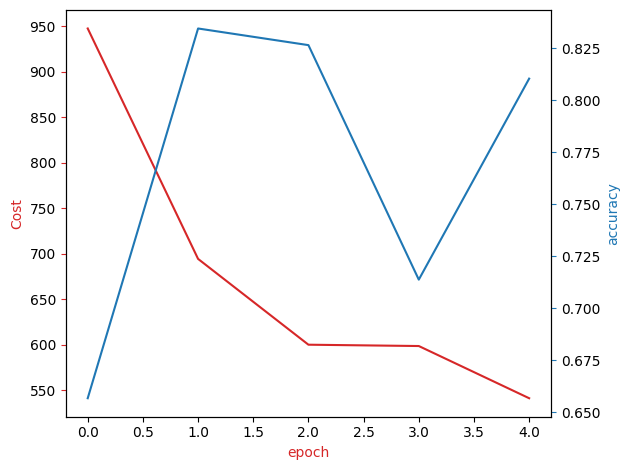

In [ ]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(train_cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [ ]:
cost_list

[tensor(1895436.1250),
 tensor(1389099.),
 tensor(1200538.3750),
 tensor(1197628.7500),
 tensor(1082903.6250)]

In [ ]:
# class CNN_model(nn.Module):

#     # Contructor
#     def __init__(self, input_tensor_dims = (3,227,227) , n_classes = 2, out_1=16, out_2=32):
#         super(CNN_model, self).__init__()

#         input_tensor_dims = np.array(input_tensor_dims)

#         kernel_size_1 , kernel_size_2  = 3 , 3
#         kernel_size_max_1 , kernel_size_max_2  = 2, 2
#         stride_1 , stride_2 = 1 , 1
#         padding_1 , padding_2 = 0 , 0

#         self.cnn1 = nn.Conv2d(in_channels=input_tensor_dims[0], out_channels=out_1, kernel_size=kernel_size_1, stride = stride_1, padding=padding_1)
#         input_tensor_dims[1:] = 1 + (input_tensor_dims[1:]-kernel_size_1)/stride_1
#         self.maxpool1=nn.MaxPool2d(kernel_size=kernel_size_max_1)
#         input_tensor_dims[1:] = input_tensor_dims[1:] / kernel_size_max_1

#         self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=kernel_size_2, stride=stride_2, padding=padding_2)
#         input_tensor_dims[1:] = 1 + (input_tensor_dims[1:]-kernel_size_2)/stride_2
#         self.maxpool2=nn.MaxPool2d(kernel_size=kernel_size_max_1)
#         input_tensor_dims[1:] = input_tensor_dims[1:] / kernel_size_max_2

#         self.fc1 = nn.Linear(out_2 * input_tensor_dims[1]*input_tensor_dims[2] , n_classes)  ### M_new = 1 + (M-K)/stride

#     # Prediction
#     def forward(self, x):

#         x = self.cnn1(x)
#         x = torch.relu(x)
#         x = self.maxpool1(x)

#         x = self.cnn2(x)
#         x = torch.relu(x)
#         x = self.maxpool2(x)

#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         return x

#     # Outputs in each steps
#     def activations(self, x):

#         #outputs activation this is not necessary
#         z1 = self.cnn1(x)
#         a1 = torch.relu(z1)
#         out = self.maxpool1(a1)

#         z2 = self.cnn2(out)
#         a2 = torch.relu(z2)
#         out1 = self.maxpool2(a2)
#         out = out.view(out.size(0),-1)

#         return z1, a1 , z2 , a2 , out1 , out

<b>Model Object:</b>


In [ ]:
# model = CNN_model()

<b>Optimizer:</b>


In [ ]:
# learning_rate = 0.01
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

<b>Criterion:</b>


In [ ]:
# criterion = nn.CrossEntropyLoss()

<b>Data Loader Training and Validation:</b>


In [ ]:
# train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100)
# validation_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=5000)

<b>Train Model with 5 epochs, should take 35 minutes: </b>


In [ ]:
# # Train the model

# n_epochs=2
# cost_list=[]
# accuracy_list=[]
# N_test=len(dataset_val)
# COST=0
# def train_model(n_epochs):
#     for epoch in range(n_epochs):
#         COST=0
#         for x, y in tqdm(train_loader):
#             optimizer.zero_grad()
#             z = model(x)
#             loss = criterion(z, y)
#             loss.backward()
#             optimizer.step()
#             COST+=loss.data

#         cost_list.append(COST)
#         correct=0
#         #perform a prediction on the validation  data
#         for x_test, y_test in validation_loader:
#             z = model(x_test)
#             _, yhat = torch.max(z.data, 1)
#             correct += (yhat == y_test).sum().item()
#         accuracy = correct / N_test
#         accuracy_list.append(accuracy)

# train_model(n_epochs)

<h2>About the Authors:</h2>
 <a href=\"https://www.linkedin.com/in/joseph-s-50398b136/\">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.



## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-18  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |



Copyright &copy; 2019 <a href="cognitiveclass.ai"> cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">MIT License</a>
